In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.max_columns', 5000)
from tqdm import tqdm
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from keras import regularizers
from keras.metrics import MeanAbsoluteError
from keras import layers as l
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline
#!pip install category_encoders
from sklearn.model_selection import  train_test_split
from sklearn import model_selection
from category_encoders import TargetEncoder

In [11]:
data = pd.read_csv("train_los.csv")
test = pd.read_csv("test_los.csv")
submission_csv = pd.read_csv("sample_sol_los.csv")

In [12]:
submission_csv = pd.read_csv("sample_sol_los.csv")

In [4]:
extra_diagnoses = pd.read_csv("extra_diagnoses.csv")

In [5]:
extra_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [6]:
extra = extra_diagnoses.copy()
unique = data["subject_id"].unique()
unique

array([55440, 28424, 86233, ...,  9725, 22337, 94290], dtype=int64)

In [7]:
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})


100%|██████████| 10959/10959 [01:06<00:00, 164.37it/s]


In [8]:
unique = data["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
    

100%|██████████| 13025/13025 [01:08<00:00, 190.21it/s]


In [9]:
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 13025/13025 [01:08<00:00, 191.38it/s]


In [10]:
data["num_stays"] = data["subject_id"].map(dicto)
data["num_dis"] = data["hadm_id"].map(dicto2)
data["dis"] = data["hadm_id"].map(dicto3)

In [11]:
data["dis"].head(10)

0    [5789, 51881, 41071, 42831, 42732, 2851, 53550...
1    [56211, 5185, 9973, 5180, 9341, 99859, 6822, 9...
2    [1625, 5185, 486, 5180, 9341, 5119, 5990, 2762...
3    [49322, 5849, 27651, 4659, 40390, 5859, 25002,...
4    [41511, 42831, 5119, 5121, 1628, 1985, 29632, ...
5    [4241, 99812, 41401, 4139, 4019, 2724, 25000, ...
6    [41011, 5845, 42821, 7907, 4280, 5853, 42731, ...
7    [3941, 3940, 5849, 5990, 2851, 5119, 4239, 427...
8    [85206, 2930, 8024, 8026, 8028, 87349, 29690, ...
9    [41401, 42823, 4271, 45829, 2875, 4254, 25000,...
Name: dis, dtype: object

In [12]:
unique = test["subject_id"].unique()
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})
unique = test["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 11217/11217 [00:58<00:00, 193.16it/s]


In [13]:
test["num_stays"] = test["subject_id"].map(dicto)
test["num_dis"] = test["hadm_id"].map(dicto2)
test["dis"] = test["hadm_id"].map(dicto3)

In [14]:
test["nthstay"] = test["hadm_id"]*np.nan
stacked = pd.concat([test,data], axis = 0)
stacked["ADMITTIME"] = pd.to_datetime(stacked["ADMITTIME"])
stacked.sort_values(by ="ADMITTIME",ascending = True, inplace = True)


In [15]:
dicto = {}
for n in tqdm(range(len(stacked))):
    temp = stacked["subject_id"].iloc[n]
    keys = dicto.keys()
    if temp in keys:
        v = dicto[temp] + 1
        dicto[temp] = v
        stacked["nthstay"].iloc[n] = v
    else:
        dicto[temp] = 1
        stacked["nthstay"].iloc[n] = 1
    

100%|██████████| 25905/25905 [00:02<00:00, 9240.00it/s]


In [16]:
test_split = stacked.iloc[13840:]
train_split = stacked.iloc[:13840]
test_split.drop("LOS", inplace = True, axis = 1)
test = test_split.copy()
data = train_split.copy()

In [17]:
test["AGE"] = (pd.to_datetime(test["ADMITTIME"])- pd.to_datetime(test["DOB"])).dt.total_seconds()//3.154e+7
data["AGE"] = (pd.to_datetime(data["ADMITTIME"])- pd.to_datetime(data["DOB"])).dt.total_seconds()//3.154e+7


In [18]:
data["NAN"] = (1*data.isna()).sum(axis = 1)
test["NAN"] = (1*test.isna()).sum(axis = 1) 

In [19]:
data.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)
test.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME"],axis =1, inplace= True)


In [20]:
data["MARITAL_STATUS"] = data["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)
test["MARITAL_STATUS"] = test["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)

In [21]:
train = data.copy()

In [22]:
#y = train["hospitalflag"]

In [23]:
train.drop("LOS", axis = 1, inplace = True)
numerical = []
for n in train.columns:
  if train[n].dtype == "int64" or train[n].dtype =="float64":
    numerical.append(n)
train.drop("DOB", axis = 1, inplace = True)
test.drop("DOB", axis = 1, inplace = True)
train.drop("RELIGION", axis = 1, inplace = True)
test.drop("RELIGION", axis = 1, inplace = True)
cat = list(set(train.columns) - set(train[numerical].columns))
y = data["LOS"]
X = train.copy()

In [24]:
train["GENDER"] = [1 if x == "M" else 0 for x in train["GENDER"]]
test["GENDER"] = [1 if x == "M" else 0 for x in test["GENDER"]]


In [25]:
from category_encoders import TargetEncoder
enc = TargetEncoder(min_samples_leaf=5)
at_train = train.copy()
at_test = test.copy()
at_train["ICD9_diagnosisT"] = enc.fit_transform(at_train["ICD9_diagnosis"], y)
at_test["ICD9_diagnosisT"] = enc.transform(at_test["ICD9_diagnosis"])

In [26]:
mix_train = pd.concat([at_train["ICD9_diagnosisT"], train["ICD9_diagnosis"]], axis = 1)
mix_test = pd.concat([at_test["ICD9_diagnosisT"], test["ICD9_diagnosis"]], axis = 1)

In [27]:
mix_train.drop_duplicates(subset=['ICD9_diagnosis'])
mix_test.drop_duplicates(subset=['ICD9_diagnosis'])

,ICD9_diagnosisT,ICD9_diagnosis
505,3.330470,95219
5349,3.683942,99812
10783,2.252513,41401
9797,2.400936,3942
6994,4.850595,56081
...,...,...
3274,3.330470,5111
7117,3.330470,0059
4442,3.330470,36522
7189,3.346895,57511


In [28]:
mix_train.index = mix_train["ICD9_diagnosis"]
mix_train.drop(["ICD9_diagnosis"], axis = 1, inplace = True)
dicto = mix_train.to_dict()

In [29]:
true_dicto = dicto["ICD9_diagnosisT"]
none_dicto = {None : np.nan}
for n in tqdm(range(len(train))):
    l = list(train["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 = [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    train["dis"].iloc[n] = v
    
for n in tqdm(range(len(test))):
    l = list(test["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 =  [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.min(v2) for x in v]
    v = np.mean(v) *np.log(np.sum(v))
    test["dis"].iloc[n] = v

100%|██████████| 12065/12065 [00:02<00:00, 4280.50it/s]


In [30]:
train_dum = pd.get_dummies(train[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
test_dum = pd.get_dummies(test[['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT']])
train.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
test.drop(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','FIRST_CAREUNIT'],axis = 1, inplace = True)
train = pd.concat([train, train_dum], axis = 1)
test = pd.concat([test, test_dum], axis = 1)

In [31]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,WHITE,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,WHITE,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,WHITE,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,OTHER,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BLACK/AFRICAN AMERICAN,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [32]:
test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
505,93.0,148.0,114.190476,98.0,123.0,110.850000,62.0,103.0,70.750000,70.0,107.0,79.75000,16.0,32.0,25.333333,36.111111,38.500000,37.259259,96.0,100.0,99.047619,111.0,145.0,134.250000,0,WHITE,T 11 INTRADURAL TUMOR,95219,1,23,10.6493,1.0,45.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5349,82.0,124.0,99.764706,86.0,169.0,117.224490,52.0,91.0,72.040816,46.0,123.0,90.92000,8.0,28.0,18.053571,34.944444,36.888889,36.352941,96.0,100.0,99.411765,65.0,142.0,88.833333,1,HISPANIC OR LATINO,PERICARDIAL HEMATOMA,99812,7,12,8.52092,6.0,34.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10783,56.0,67.0,59.724138,84.0,187.0,123.566667,49.0,92.0,70.533333,61.0,123.0,83.90000,9.0,17.0,14.464286,35.333333,37.277778,36.291667,91.0,99.0,95.714286,99.0,110.0,104.500000,1,PATIENT DECLINED TO ANSWER,CHEST PAIN\CARDIAC CATHETERIZATION,41401,1,19,9.72888,1.0,76.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9797,59.0,78.0,68.935484,90.0,137.0,111.343750,48.0,71.0,57.968750,58.0,91.0,73.90625,10.0,29.0,18.625000,36.000000,38.200000,37.090535,97.0,100.0,99.258065,85.0,212.0,120.352941,1,BLACK/CAPE VERDEAN,MITAL VALVE INSUFFICENCY\MITRAL VALVE REPLACEM...,3942,1,5,4.3273,1.0,37.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
6994,82.0,107.0,93.714286,99.0,142.0,117.240000,52.0,75.0,64.000000,68.0,90.0,76.40000,8.0,20.0,14.407407,36.555556,38.055556,37.174603,95.0,99.0,97.607143,137.0,187.0,162.000000,1,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,56081,1,7,7.69714,1.0,46.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [33]:
test_f = test.copy()
train_f = train.copy()

In [34]:
train = train_f.copy()
test = test_f.copy()

In [35]:
train.drop(["ETHNICITY"],axis = 1, inplace = True)
test.drop(["ETHNICITY"],axis = 1, inplace = True)

In [36]:
train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,NAN,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,119.0,119.000000,0,ACUTE MYELOGENOUS LEUKEMIA;DEEP VEIN THROMBOSIS,4538,1,16,10.0644,1.0,46.0,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,88.0,87.000000,1,SEPSIS,5770,2,39,13.1484,1.0,70.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,61.0,106.0,76.795455,71.0,142.0,100.673469,20.0,96.0,52.734694,38.0,98.0,67.224490,13.0,35.0,24.204545,35.555556,38.333333,36.761111,93.0,100.0,98.309524,103.0,158.0,130.500000,0,FEVER,2884,1,30,10.2332,1.0,70.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,204.0,157.111111,0,HEART FAILURE;MITRAL REGURGITATION;TRICUSPID R...,4242,1,15,8.96613,1.0,84.0,21,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10031,78.0,107.0,92.032258,104.0,145.0,124.586207,56.0,95.0,70.586207,70.0,107.0,83.310345,12.0,44.0,21.387097,35.555556,36.333333,35.952381,90.0,100.0,98.903226,145.0,231.0,179.833333,1,BRBPR,56213,1,28,11.4258,1.0,79.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [37]:
test['NAN'].value_counts(), train['NAN'].value_counts()

(0     11239
 1       401
 3       335
 4        32
 21       29
 6        23
 22        2
 9         2
 7         1
 10        1
 Name: NAN, dtype: int64,
 0     10454
 21     2610
 1       383
 3       297
 22       49
 6        18
 4        18
 7         3
 12        3
 18        2
 9         2
 16        1
 Name: NAN, dtype: int64)

In [135]:
y = data["LOS"]
train = pd.concat([y,train], axis=1)

In [136]:
train.to_csv("final_version_train.csv", index = False)
test.to_csv("final_version_test.csv", index = False)

In [20]:
train = pd.read_csv("final_version_train.csv")
test = pd.read_csv("final_version_test.csv")

In [21]:
train["NAN"] = [1 if x == 21 else 0  for x in train["NAN"]]
test["NAN"] = [1 if x ==21 else 0  for x in test["NAN"]]


(0.0, 10.0)

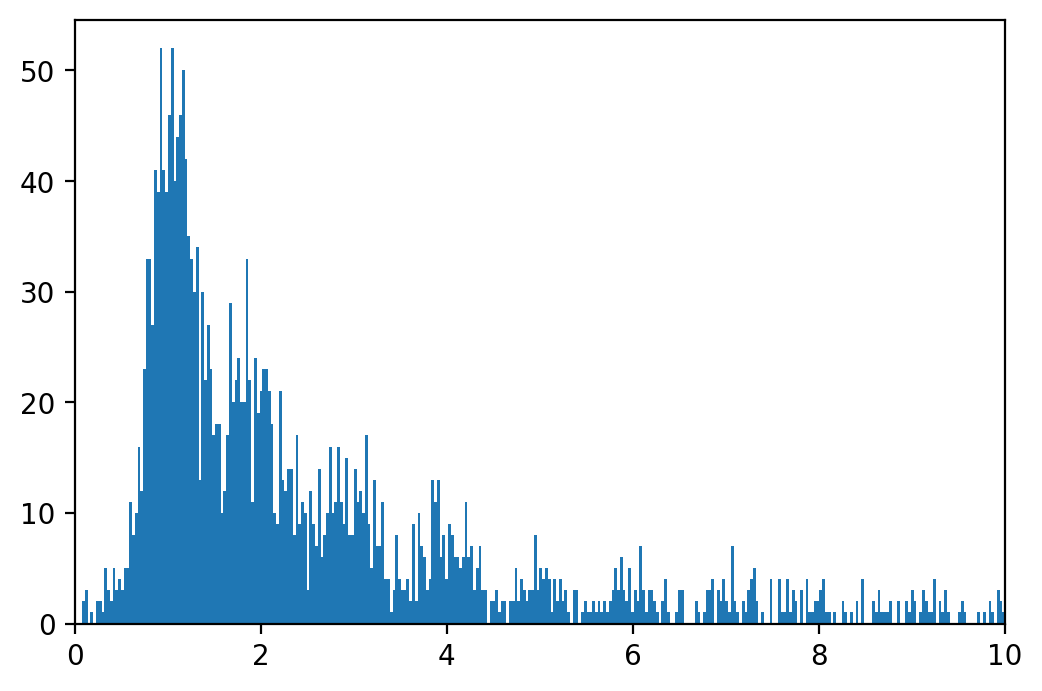

In [22]:
_=plt.hist(train.query("NAN == 1")["LOS"], bins = 1000)
plt.xlim(0,10)

In [23]:
y=train["LOS"]
train.drop("LOS", axis = 1,inplace = True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state = 123)
X_trainf, X_testf, y_trainf, y_testf= X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [25]:
cat = ["ICD9_diagnosis", "DIAGNOSIS"]

In [26]:
sc = StandardScaler()
enc = TargetEncoder(min_samples_leaf=5)
X_train[cat] = enc.fit_transform(X_train[cat], y_train) 
test[cat] = enc.transform(test[cat])
X_test[cat] = enc.transform(X_test[cat])

X_train.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)
X_test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)
test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)

hasnan = []
for n in X_train.columns:
    if X_train[n].isnull().values.any() == True:
        hasnan.append(n)
hasnan2 = []        
for n in test.columns:
    if test[n].isnull().values.any() == True:
        hasnan2.append(n)
hasnan3 = []        
for n in X_test.columns:
    if X_test[n].isnull().values.any() == True:
        hasnan3.append(n)
        
        
X_train[hasnan] = X_train[hasnan].apply(lambda x: x.fillna(x.mean()),axis=0)
test[hasnan2] = test[hasnan2].apply(lambda x: x.fillna(x.mean()),axis=0)
X_test[hasnan3] = X_test[hasnan3].apply(lambda x: x.fillna(x.mean()),axis=0)

X_train = pd.concat([y_train, X_train],axis = 1)
X_test = pd.concat([y_test, X_test],axis = 1)


X_train = X_train.query("NAN != 1")
test = test.query("NAN != 1")
X_test = X_test.query("NAN != 1")

y_train = X_train["LOS"]
y_test = X_test["LOS"]
X_train.drop("LOS", axis =1, inplace = True)
X_test.drop("LOS", axis =1, inplace = True)

X_test.drop("NAN", inplace = True, axis =1)
test.drop("NAN", inplace = True, axis =1)
X_train.drop("NAN", inplace = True, axis =1)

In [33]:
train_dum = train.iloc[:,33:]


In [34]:
dum = list(train_dum.columns)
dum.append("GENDER")
ss = list(set(X_train.columns) - set(dum))
ss

['DiasBP_Mean',
 'num_stays',
 'DiasBP_Max',
 'ICD9_diagnosis',
 'SysBP_Max',
 'TempC_Min',
 'RespRate_Max',
 'MeanBP_Mean',
 'HeartRate_Mean',
 'SpO2_Min',
 'dis',
 'RespRate_Min',
 'SysBP_Min',
 'TempC_Max',
 'HeartRate_Max',
 'DIAGNOSIS',
 'SysBP_Mean',
 'TempC_Mean',
 'nthstay',
 'RespRate_Mean',
 'DiasBP_Min',
 'AGE',
 'HeartRate_Min',
 'num_dis',
 'SpO2_Max',
 'MeanBP_Max',
 'MeanBP_Min',
 'SpO2_Mean']

In [35]:
X_test[ss].isnull().values.any()

False

In [36]:
X_train[ss] =sc.fit_transform(X_train[ss])
X_test[ss] = sc.transform(X_test[ss])
test[ss] = sc.transform(test[ss]) 


In [37]:
X_trainf.shape, X_testf.shape, y_trainf.shape, y_testf.shape

((10380, 53), (3460, 53), (10380,), (3460,))

In [38]:
X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,DIAGNOSIS,ICD9_diagnosis,num_stays,num_dis,dis,nthstay,AGE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
6748,1.428990,0.855915,1.265585,-1.039944,-1.694539,-1.681096,-0.299251,-0.887769,-0.741648,-0.592105,-1.031678,-1.347106,-0.807890,1.503168,-0.231781,-0.674764,0.089616,-1.083640,-0.521553,0.379901,-0.587383,0,-0.271344,-2.802776,0.655837,-0.238158,-0.053564,1.189258,-1.134448,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1578,0.556661,0.423370,0.303230,-0.591072,-1.196276,-1.062997,-1.058043,-1.349844,-1.013772,-0.730564,-1.172681,-1.320017,3.364811,2.629820,3.194638,1.370398,1.490652,1.867443,0.009989,0.379901,-0.190709,1,-0.582175,0.189018,-0.381075,1.016189,0.639745,-0.325193,1.169539,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
13783,-0.516975,-0.922326,-0.732605,1.821612,2.748303,3.072278,0.375231,0.498455,0.712073,0.861711,0.871868,1.711034,0.583011,-0.267284,0.429309,0.006957,0.019565,-0.341168,0.009989,-1.253311,-0.444720,1,-0.232994,-0.099841,-0.381075,-0.656273,-0.994081,-0.325193,-0.212853,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
12816,3.039444,2.826398,3.880533,1.204414,0.298512,1.248329,-0.130631,-0.682403,0.059796,0.515565,-0.361912,0.399767,-1.364250,0.054616,0.397298,1.370398,0.930238,1.665043,-2.381951,-2.069918,-0.973618,0,-1.685520,4.988771,-0.381075,-0.935017,0.070637,-0.325193,0.535943,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
10560,0.086945,-0.009176,0.185135,1.372741,1.876343,2.317526,0.122300,0.190405,1.050702,0.654023,0.272604,1.580397,-0.807890,0.698417,-0.722029,-0.674764,-0.400746,-0.392495,-0.255782,0.379901,-0.284658,1,-0.582175,-1.022224,0.655837,1.434304,0.532243,0.432033,0.305544,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [39]:
import kerastuner as kt
from keras import layers as l

In [40]:
X_train_auto = X_train.iloc[:,:29]
X_test_auto = X_test.iloc[:,:29]
test_auto = test.iloc[:,:29]


input_data = keras.Input(shape=(29,))
encoded = l.Dense(29, activation='relu', activity_regularizer=keras.regularizers.l1_l2(None, None))(input_data)

encoded = l.Dense(25)(encoded)

decoded = l.Dense(29, activation='linear')(encoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss='mse')
autoencoder.fit(X_train_auto, X_train_auto,
                epochs=35,
                batch_size=64,
                verbose = 2,
                validation_data=(X_test_auto, X_test_auto))



encoder = keras.Model(inputs=input_data, outputs=encoded)


Z = pd.DataFrame(encoder.predict(X_train_auto))
Zt = pd.DataFrame(encoder.predict(X_test_auto))
TT = pd.DataFrame(encoder.predict(test_auto))
print(Z.shape, Zt.shape,  TT.shape)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                754       
Total params: 2,374
Trainable params: 2,374
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
132/132 - 1s - loss: 0.8220 - val_loss: 0.5257
Epoch 2/35
132/132 - 0s - loss: 0.4042 - val_loss: 0.3364
Epoch 3/35
132/132 - 0s - loss: 0.2854 - val_loss: 0.2553
Epoch 4/35
132/132 - 0s - loss: 0.2256 - val_loss: 0.2038
Epoch 5/35
132/132 - 0s -

In [41]:
Z.reset_index(drop=True, inplace=True)
Zt.reset_index(drop=True, inplace=True)
TT.reset_index(drop=True, inplace=True)
z1 = X_train.iloc[:,29:]
z1.reset_index(drop=True, inplace=True)
z2 = X_test.iloc[:,29:]
z2.reset_index(drop=True, inplace=True)
z3 = test.iloc[:,29:]
z3.reset_index(drop=True, inplace=True)

a = pd.concat([Z,z1],axis=1)
b = pd.concat([Zt,z2],axis=1)
c = pd.concat([TT, z3],axis=1)
Z = a
Zt=b
TT=c


Z.shape, Zt.shape, TT.shape

((8427, 45), (2803, 45), (12036, 45))

In [43]:
N_INPUTS = X_test.shape[1]

class MyTuner(kt.tuners.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',values=[32, 64, 128, 256],default=64)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

Below begins a boring part. feel free to skip all the way to the bottom where we deal with the data using a slightly different aproach which does not return the median/mean as the best guess. That part is actually a result of very long time of period spent on finetuning the predictions only to be all discarded the second i looked on how the NANs were distributed. Oh irony, the NAN column was actually the first feature created for the day2 assigment and I havent looked into it till after wasting way too many hours trying to figure out why the kaggle dataset prediction collapses when we use anyother imputation than a mean/median.While its lenght is kept to minimum, the first attempt to perfect this method had more or less 100 cells.

In [44]:
def loss_function(y_true, y_pred):
        a = (y_pred - y_true)
        #a = tf.where(tf.less_equal(a, 1), a, a**2)
        return (tf.reduce_mean(abs(a))) 



def reg(hp):
    
    model = Sequential()
    act = hp.Choice('dense_activation',values=['relu', 'selu','elu'],default='selu')
    hp_reg2 = hp.Float('regularizers_2', min_value=0.00000001, max_value=1, default=0.01,sampling='LOG') 
    hp_reg1 = None 
    drop = hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    
    units_0 = hp.Choice('units_0',values=[64, 96, 128, 160, 192],default=96)
    units_1 = hp.Choice('units_1',values=[64, 96, 128],default=64)
    units_2 = hp.Choice('units_2',values=[48, 64, 96],default=64)
    
    model.add(l.Dense(units = units_0, use_bias=True,  input_dim=N_INPUTS, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dense(units = units_0,
                      use_bias=True,  activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    
    model.add(l.Dense(1, activation ="relu"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss=hp.Choice('loss',values=['mse', 'mae'],default='mae'),metrics=['mae'])
    return model


In [45]:
def regBIG(hp):
    model = Sequential()
    
    hp_reg2 = hp.Float('regularizers_2', min_value=0.00000001, max_value=1, default=0.01,sampling='LOG') 
    hp_reg1 = None 
    act = hp.Choice('dense_activation',values=['relu', 'selu','elu'],default='selu')
    
    units_0 = hp.Choice('units_0',values=[64,96, 128, 160, 192],default=96)
    units_1 = hp.Choice('units_1',values=[64, 96, 128],default=64)
    units_2 = hp.Choice('units_2',values=[48, 64, 96],default=64)
    
    drop = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    
    model.add(l.Dense(units = units_0, use_bias=True,  input_dim=N_INPUTS, activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dense(units = units_0,
                      use_bias=True,  activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop ))
    model.add(l.Dense(units = units_0, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    model.add(l.Dropout(rate = drop))
    

    model.add(l.Dense(1, activation ="relu"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss=hp.Choice('loss',values=['mse', 'mae'],default='mae'),metrics='mae')
    return model

In [46]:
all_modelsN = []
all_modelsL = []

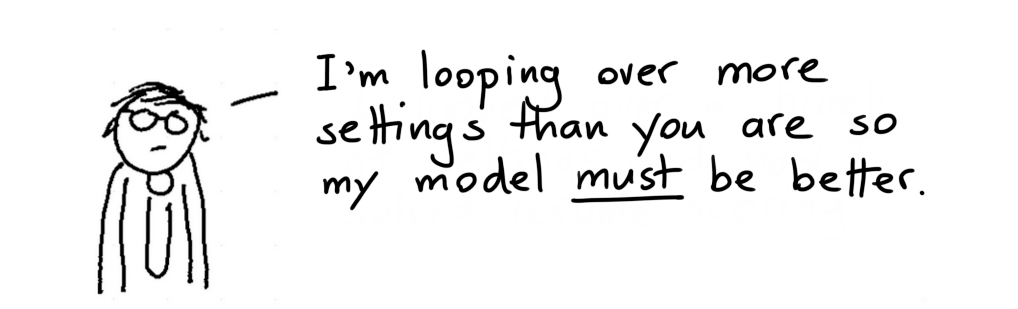
-koaning.io

In [47]:
tuner = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'N')
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 02s]
val_mae: 2.4649431705474854

Best val_mae So Far: 2.1568219661712646
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit


In [48]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
all_modelsN.append(best_model)
best_model.summary()
tuner.results_summary()

88/88 [==============================] - 0s 2ms/step - loss: 24.3504 - mae: 2.2007
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               9600      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                18528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_______________________________________

In [49]:
tunerB = MyTuner(regBIG, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15, project_name = 'BN')
tunerB.search(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 03s]
val_mae: 2.5600357055664062

Best val_mae So Far: 2.1578166484832764
Total elapsed time: 00h 05m 28s
INFO:tensorflow:Oracle triggered exit


In [50]:
best_modelB = tunerB.get_best_models(num_models=1)[0]
loss, mae = best_modelB.evaluate(X_test, y_test)
all_modelsN.append(best_modelB)
best_modelB.summary()
tunerB.results_summary()

88/88 [==============================] - 1s 3ms/step - loss: 2.3630 - mae: 2.2015
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                4800      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               12416     
________________________________________

In [51]:
pred = best_model.predict(test)


In [52]:
np.max(pred), np.min(pred), np.mean(pred), np.var(pred)

(2.157432, 1.7646519, 1.9535648, 0.0022941618)

In [53]:
y_testL = np.log(y_test)
y_trainL = np.log(y_train)


That should have been done by defining a function. I didn't realize how much copying and pasting I have done untill I decided to actually count the number of searches there is (8 for regress task 12 for classification).

In [54]:
tunerL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15, project_name = 'L')
tunerL.search(X_train, y_trainL, epochs = 20, validation_data = (X_test, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 02s]
val_mae: 0.693330705165863

Best val_mae So Far: 0.6733973026275635
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit


In [55]:
tunerBL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15, project_name = 'BL')
tunerBL.search(X_train, y_trainL, epochs = 20, validation_data = (X_test, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 02s]
val_mae: 0.6891254782676697

Best val_mae So Far: 0.6733937859535217
Total elapsed time: 00h 03m 35s
INFO:tensorflow:Oracle triggered exit


In [56]:
best_modelL = tunerL.get_best_models(num_models=1)[0]
loss, mae = best_modelL.evaluate(X_test, y_testL)
all_modelsL.append(best_modelL)
best_modelL.summary()
tunerL.results_summary()

88/88 [==============================] - 0s 2ms/step - loss: 22.1795 - mae: 0.6894
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               9600      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                18528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_______________________________________

In [57]:
best_modelBL = tunerBL.get_best_models(num_models=1)[0]
loss, mae = best_modelBL.evaluate(X_test, y_testL)
all_modelsL.append(best_modelBL)
best_modelBL.summary()
tunerBL.results_summary()


88/88 [==============================] - 0s 2ms/step - loss: 0.7565 - mae: 0.6891
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                4800      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
________________________________________

In [58]:
N_INPUTS = Z.shape[1]

In [59]:
tunerZ = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'ZN')
tunerZ.search(Z, y_train, epochs = 20, validation_data = (Zt, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 03s]
val_mae: 2.46490216255188

Best val_mae So Far: 2.1574440002441406
Total elapsed time: 00h 04m 07s
INFO:tensorflow:Oracle triggered exit


In [60]:
best_modelZ = tunerZ.get_best_models(num_models=1)[0]
loss, mae = best_modelZ.evaluate(Zt, y_test)
all_modelsN.append(best_modelZ)
best_modelZ.summary()
tunerZ.results_summary()

88/88 [==============================] - 1s 2ms/step - loss: 2.8534 - mae: 2.2009
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               8832      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
________________________________________

In [61]:
tunerZB = MyTuner(regBIG, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'ZBN')
tunerZB.search(Z, y_train, epochs = 20, validation_data = (Zt, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 03s]
val_mae: 2.457622528076172

Best val_mae So Far: 2.1578171253204346
Total elapsed time: 00h 06m 38s
INFO:tensorflow:Oracle triggered exit


In [62]:
best_modelZB = tunerZB.get_best_models(num_models=1)[0]
loss, mae = best_modelZB.evaluate(Zt, y_test)
all_modelsN.append(best_modelZB)
best_modelZB.summary()
tunerZB.results_summary()

88/88 [==============================] - 1s 3ms/step - loss: 2.2027 - mae: 2.2015
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2944      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                6240      
________________________________________

In [63]:
tunerZL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'ZL')
tunerZL.search(Z, y_trainL, epochs = 20, validation_data = (Zt, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 03s]
val_mae: 0.6872756481170654

Best val_mae So Far: 0.673183023929596
Total elapsed time: 00h 05m 16s
INFO:tensorflow:Oracle triggered exit


In [64]:
tunerZBL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'ZBL')
tunerZBL.search(Z, y_trainL, epochs = 20, validation_data = (Zt, y_testL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 02s]
val_mae: 0.6893266439437866

Best val_mae So Far: 0.6734899878501892
Total elapsed time: 00h 04m 26s
INFO:tensorflow:Oracle triggered exit


In [65]:
best_modelZL = tunerZL.get_best_models(num_models=1)[0]
loss, mae = best_modelZL.evaluate(Zt, y_testL)
all_modelsL.append(best_modelZL)
best_modelZL.summary()
tunerZL.results_summary()

88/88 [==============================] - 0s 2ms/step - loss: 0.9363 - mae: 0.6885
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                4416      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
________________________________________

In [66]:
best_modelZBL = tunerZBL.get_best_models(num_models=1)[0]
loss, mae = best_modelZBL.evaluate(Zt, y_testL)
all_modelsL.append(best_modelZBL)
best_modelZBL.summary()
tunerZBL.results_summary()

88/88 [==============================] - 0s 2ms/step - loss: 0.7326 - mae: 0.6892
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                4416      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
________________________________________

In [67]:
prediction = 0
for n in all_modelsN:
    try:
        N_INPUTS = Z.shape[1]
        temp = n.predict(Z)
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_train, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = n.predict(X_train)
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_train, temp))
    
predN = prediction / len(all_modelsN)
mean_absolute_error(y_train, predN)

2.175074 1.7544649 1.9520077 0.0024171178
2.059131184871615
1.9539675 1.9539675 1.9539677 5.684342e-14
2.0625268479758145
2.152409 1.8895591 1.9497185 0.00036291528
2.060759040083885
1.9516531 1.9516531 1.9516528 1.2789769e-13
2.062616130154393


2.0611282550909547

In [68]:
prediction = 0
for n in all_modelsL:
    try:
        N_INPUTS = Z.shape[1]
        temp = np.exp(n.predict(Z))
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_train, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = np.exp(n.predict(X_train))
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_train, temp))
    
predL = prediction / len(all_modelsL)
mean_absolute_error(y_train, predL)

2.185064 1.835922 1.9788936 0.0013138884
2.060619505224865
2.0926504 1.932997 1.952499 0.00011356443
2.0613586770825303
2.6523635 1.8752419 1.9546162 0.0012928995
2.0590117445709786
1.9932647 1.9379046 1.9486849 1.7666942e-05
2.062266702261997


2.0606127281984317

(0.0, 10.0)

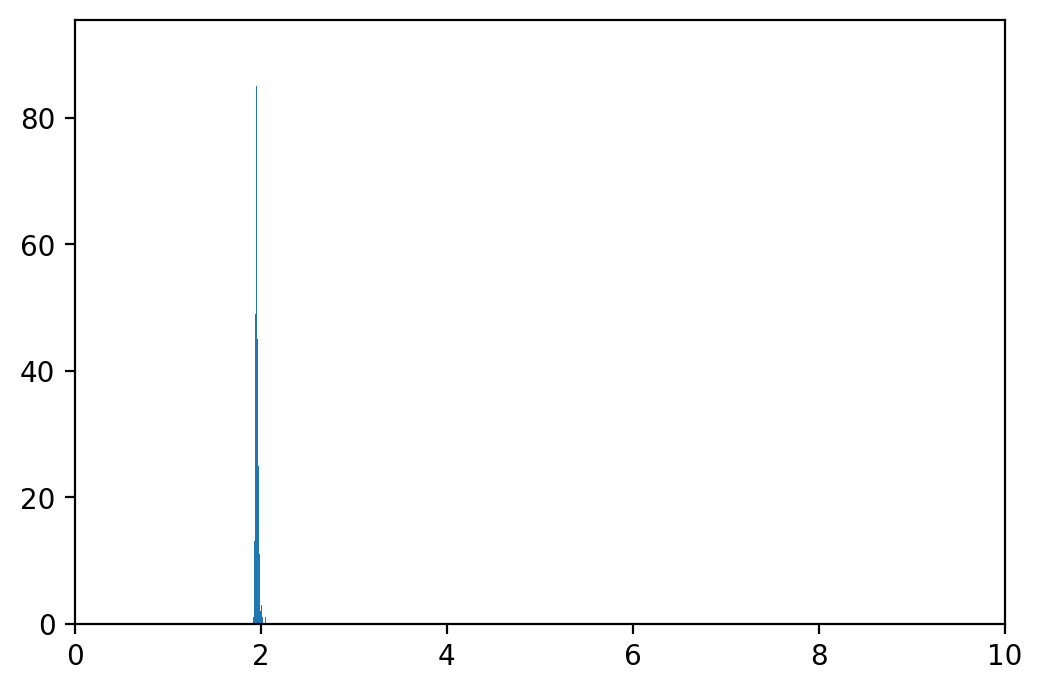

In [69]:
_=plt.hist(predL,bins=1000)
plt.xlim(0,10)


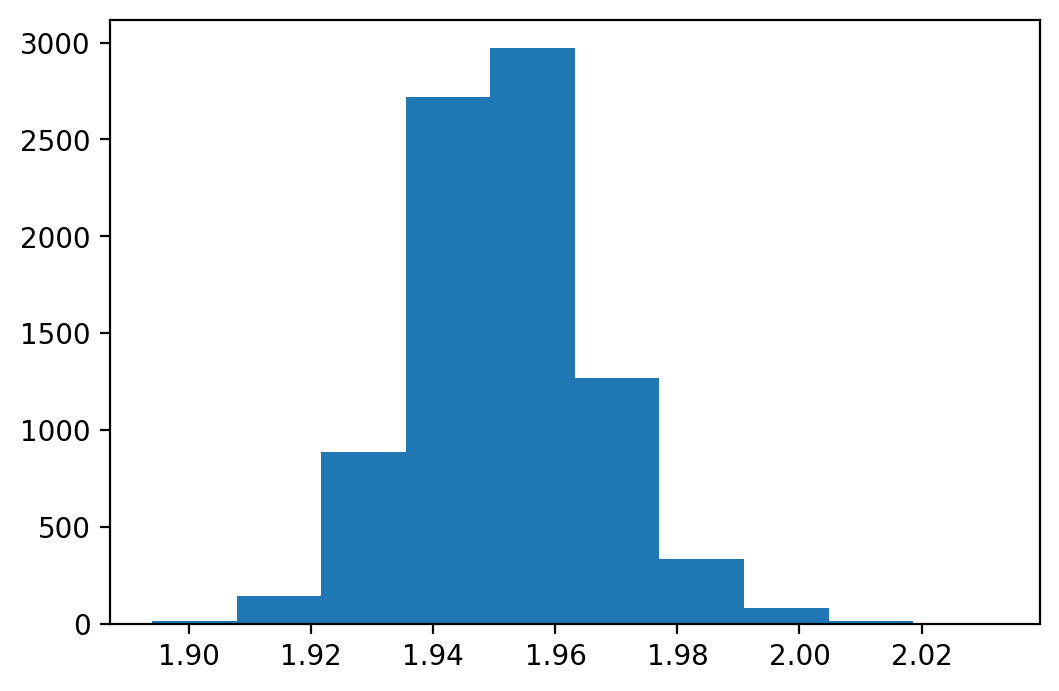

In [70]:
_=plt.hist(predN)


In [71]:
prediction = 0
for n in all_modelsN:
    try:
        N_INPUTS = Z.shape[1]
        temp = n.predict(Zt)
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_test, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = n.predict(X_test)
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_test, temp))
    
predN2 = prediction / len(all_modelsN)
mean_absolute_error(y_test, predN2)

2.1595588 1.770598 1.9538727 0.0023149524
2.156821741019408
1.9539675 1.9539675 1.9539676 1.4210855e-14
2.157815673402765
2.2545853 1.8929725 1.9495142 0.00039490784
2.1574444107531994
1.9516531 1.9516531 1.9516532 1.4210855e-14
2.1578170654247204


2.1573592505522043

In [72]:
prediction = 0
for n in all_modelsL:
    try:
        N_INPUTS = Z.shape[1]
        temp = np.exp(n.predict(Zt))
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_test, temp))
    except:
        N_INPUTS = X_test.shape[1]
        temp = np.exp(n.predict(X_test))
        prediction += temp
        print(np.max(temp), np.min(temp), np.mean(temp), np.var(temp))
        print(mean_absolute_error(y_test, temp))
    
predL2 = prediction / len(all_modelsL)
mean_absolute_error(y_test, predL2)

2.1808546 1.8430008 1.9796497 0.0012522652
2.1576014225489915
2.1627011 1.9333873 1.9525204 0.00013300455
2.1575905191937306
2.9733837 1.8801391 1.9541062 0.0017403172
2.157165826581301
2.0105326 1.9383596 1.9486251 1.9194062e-05
2.1577848912338085


2.157277213740204

stop scrolling here

In [73]:
X_train_sub = X_train[y_train<3.5]
y_train_sub = y_train[y_train<3.5]
#this was part of an attempt to pinpoint patients that are more likel;y to stay longer and model them using something that would deal better on a skewed data

X_test_sub = X_test[y_test<3.5]
y_test_sub = y_test[y_test<3.5]

In [74]:
N_INPUTS = X_test.shape[1]
tuner5 = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'fin')
tuner5.search(X_train_sub, y_train_sub, epochs = 10, validation_data = (X_test_sub, y_test_sub), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 04s]
val_mae: 0.6441054344177246

Best val_mae So Far: 0.6340592503547668
Total elapsed time: 00h 03m 58s
INFO:tensorflow:Oracle triggered exit


In [75]:
best_model5 = tuner5.get_best_models(num_models=1)[0]
loss, mae = best_model5.evaluate(X_test, y_test)
best_model5.summary()
tuner5.results_summary()

88/88 [==============================] - 0s 3ms/step - loss: 19.6294 - mae: 2.2684
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                4800      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_______________________________________

(0.0, 5.0)

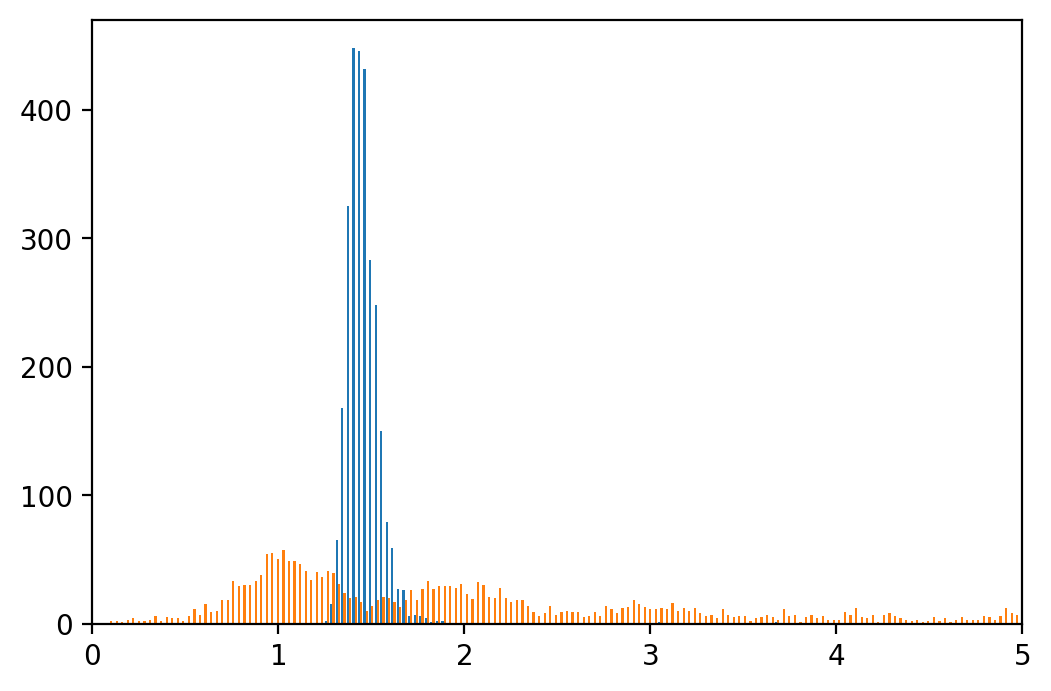

In [76]:
pred = best_model5.predict(X_test)
_=plt.hist([pred.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

In [77]:
y_train_subL = np.log(y_train_sub)
y_test_subL = np.log(y_test_sub)
N_INPUTS = X_test.shape[1]
tuner5L = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=4, seed = 2137, max_epochs = 15,  project_name = 'finL')
tuner5L.search(X_train_sub, y_train_subL, epochs = 10, validation_data = (X_test_sub, y_test_subL), callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)])

Trial 52 Complete [00h 00m 04s]
val_mae: 0.42021605372428894

Best val_mae So Far: 0.4178445637226105
Total elapsed time: 00h 04m 12s
INFO:tensorflow:Oracle triggered exit


In [78]:
best_model5L = tuner5L.get_best_models(num_models=1)[0]
loss, mae = best_model5L.evaluate(X_test, y_test)
best_model5L.summary()
tuner5.results_summary()

88/88 [==============================] - 1s 3ms/step - loss: 25.0315 - mae: 3.0238
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               9600      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               37056     
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_______________________________________

(0.0, 5.0)

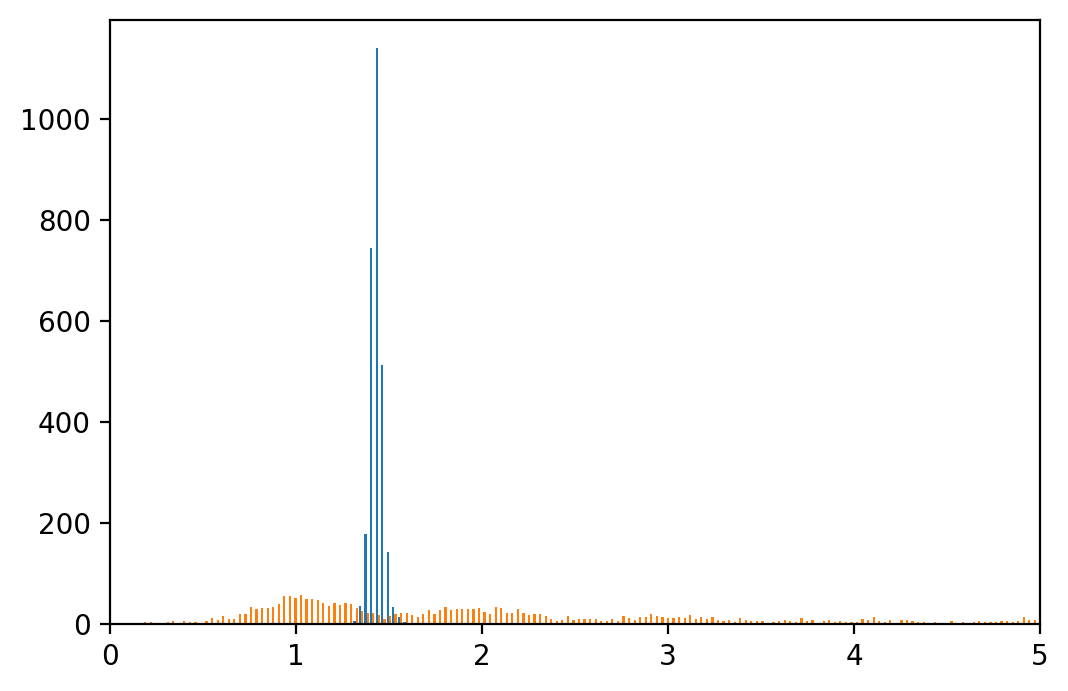

In [79]:
predL = np.exp(best_model5L.predict(X_test))
_=plt.hist([predL.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

In [ ]:
def submit(prediction, name):
    my_submission = submission_csv 
    my_submission["LOS"] =  prediction
    my_submission = my_submission
    my_submission.to_csv(name, index=False)
submit(very_nice, "dfsfg.csv")